## First we import the classes that we need for opening and reading files. We use h5py to allow Python to read the h5 file format, and numpy for building arrays. We also have to import matplotlib for plotting on the first line, due to a strangeness in the matplotlib package.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np

## We open up four different ROOT files, each containing 1000 events with a single-particle gun at different energies. We have charged pions, photons, neutron pions, and electrons. For now we'll only open one file of each type.

In [2]:
dataDir = "/data/LCD/V1/HLF/"
dataFileNames = ["EleEscan_HLF/EleEscan_1_10_HLF.h5", "GammaEscan_HLF/GammaEscan_1_10_HLF.h5", "ChPiEscan_HLF/ChPiEscan_1_10_HLF.h5", "Pi0Escan_HLF/Pi0Escan_1_10_HLF.h5"]
#dataFileNames = []
#for i in range(9, 11):
#    dataFileNames.append("gamma_" + str(i) + "_GeV.h5")
#    dataFileNames.append("pi0_" + str(i) + "_GeV.h5")

In [3]:
dataFiles = []
for i in range(len(dataFileNames)):
    dataFiles.append(h5py.File(dataDir + dataFileNames[i], "r"))

## This next command tells us all the features stored in the files. It's possible to define more features when producing the h5 files, but these will do for now. We can make simple plots to look at these distributions.

In [4]:
print dataFiles[0].keys()

[u'ECALMeasuredEnergy', u'ECALMoment1X', u'ECALMoment1Y', u'ECALMoment1Z', u'ECALMoment2X', u'ECALMoment2Y', u'ECALMoment2Z', u'ECALMoment3X', u'ECALMoment3Y', u'ECALMoment3Z', u'ECALMoment4X', u'ECALMoment4Y', u'ECALMoment4Z', u'ECALMoment5X', u'ECALMoment5Y', u'ECALMoment5Z', u'ECALMoment6X', u'ECALMoment6Y', u'ECALMoment6Z', u'ECALNumberOfHits', u'ECAL_HCAL_ERatio', u'ECAL_HCAL_nHitsRatio', u'ECAL_ratioFirstLayerToSecondLayerE', u'ECAL_ratioFirstLayerToTotalE', u'Energy', u'HCALMeasuredEnergy', u'HCALMoment1X', u'HCALMoment1Y', u'HCALMoment1Z', u'HCALMoment2X', u'HCALMoment2Y', u'HCALMoment2Z', u'HCALMoment3X', u'HCALMoment3Y', u'HCALMoment3Z', u'HCALMoment4X', u'HCALMoment4Y', u'HCALMoment4Z', u'HCALMoment5X', u'HCALMoment5Y', u'HCALMoment5Z', u'HCALMoment6X', u'HCALMoment6Y', u'HCALMoment6Z', u'HCALNumberOfHits', u'HCAL_ratioFirstLayerToSecondLayerE', u'HCAL_ratioFirstLayerToTotalE', u'pdgID']


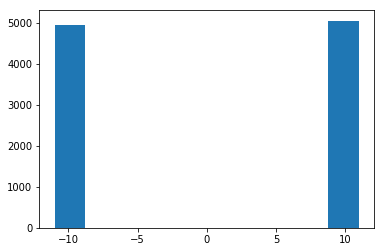

In [5]:
plt.hist(dataFiles[0]['pdgID']);

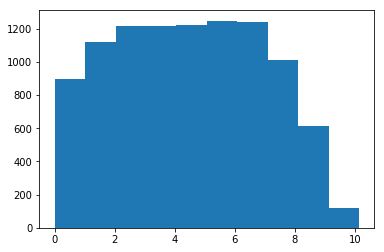

In [6]:
plt.hist(dataFiles[1]['ECALMeasuredEnergy']);
#etc.

## Now we combine samples, and explicitly label the electrons as class '0', photons as class '1', charged pions as class '2', and neutral pions as class '3'.

In [7]:
data = []
features = dataFiles[0].keys()
# remove the "Energy" feature, which contains truth information about the particle gun
features.remove('Energy')

for count, feature in enumerate(features):
    
    newFeature = []
    for fileN in range(len(dataFiles)):
        newFeature += dataFiles[fileN][feature]

    # use "pdgID" as the truth classifier y - all other features go into matrix X
    if feature == 'pdgID':
        y = 0 * np.array([int(abs(x) == 11) for x in newFeature]);
        y = y + 1 * np.array([int(abs(x) == 22) for x in newFeature]);
        y = y + 2 * np.array([int(abs(x) == 211) for x in newFeature]);
        y = y + 3 * np.array([int(abs(x) == 111) for x in newFeature]);
    else:
        data.append(newFeature);

X = np.column_stack(data)

# remove all rows containing NaN and inf (from zero energy deposition, e.g.)
y = y[np.isfinite(X).all(axis=1)]
X = X[np.isfinite(X).all(axis=1)]

## Now we import the sklearn package to perform BDT training. First, we split the data into 2/3 training data and 1/3 test data.

In [ ]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=492)

/home/afarbin/.virtualenvs/keras2/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## We set up a BDT with a maximum depth of 5 and the AdaBoost-SAMME algorithm. We set 800 estimators and a learning rate of 0.5. If we wanted to, we could further split the training data into training and validation data. This would allow us to compare results from using different training parameters.

## AdaBoost is explained here: http://algorithm-interest-group.me/assets/slides/AdaBoost.pdf

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=5)
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)

bdt.fit(X_train, y_train)

## The result of the training is shown below.

## Precision (P) is defined as the number of true positives (T_p) over the number of true positives plus the number of false positives (F_p). E.g. the number of correctly identified electrons over all particles identified as electrons.
## P = T_p / (T_p+F_p)  

## Recall (R) is defined as the number of true positives (T_p) over the number of true positives plus the number of false negatives (F_n). E.g. the number of correctly identified electrons over all truth electrons.
## R = T_p / (T_p + F_n)

In [ ]:
y_predicted = bdt.predict(X_test)
target_names = ['electron', 'photon', 'charged pion', 'neutral pion']
print (classification_report(y_test, y_predicted, target_names=target_names))

## We see that charged pions are identified very well, followed by electrons, but that the BDT has a bit of trouble distinguishing photons and neutron pions. We can look at a ROC curve for identifying just these two classes - photons vs. neutral pions.

In [ ]:
y_photon.shape

In [ ]:
scores[indicesOfInterest][:,1].shape

In [ ]:
from sklearn.metrics import roc_curve, auc

scores = bdt.decision_function(X_test)

# photons
indicesOfInterest = np.array([(y == 1 or y == 3) for y in y_test])
y_photon = np.array([int(y == 1) for y in y_test[indicesOfInterest]])
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_photon, scores[indicesOfInterest][:,1])))

fpr, tpr, thresholds = roc_curve(y_photon, scores[indicesOfInterest][:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Finally, we can look at signal performance over background for a single class (let's say signal = photons, background = neutral pions) to test for overtraining. 

In [ ]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train[indicesOfInterest], y_train[indicesOfInterest]), (X_test[indicesOfInterest], y_test[indicesOfInterest])):
        d1 = clf.decision_function(X[y==1]).ravel()
        d2 = clf.decision_function(X[y==3]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0], color='r', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', normed=True, label='S (train)')
    plt.hist(decisions[1], color='b', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', normed=True, label='B (train)')

    hist, bins = np.histogram(decisions[2], bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3], bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, X_train, y_train, X_test, y_test)